






























































































































# Importing packages 

In [1]:
# Data wrangling 
import pandas as pd 

# Array math
import numpy as np 

# Ploting 
import seaborn as sns
import matplotlib.pyplot as plt

# List iteration tracking
from tqdm import tqdm

# Importing the custom written class 
from DecisionTree import Node 

# Importing the scikit-learn tree implementation
from sklearn.tree import DecisionTreeClassifier, export_text 

# Inspecting functions
import inspect

# Time tracking
import time

# Motivating example

Lets load some data from the famous titanic dataset.

In [2]:
# Loading data
d = pd.read_csv('data/train.csv')

In [3]:
d.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
280,281,0,3,"Duane, Mr. Frank",male,65.0,0,0,336439,7.750,NaN,Q
129,130,0,3,"Ekstrom, Mr. Johan",male,45.0,0,0,347061,6.975,NaN,S
754,755,1,2,"Herman, Mrs. Samuel (Jane Laver)",female,48.0,1,2,220845,65.000,NaN,S
525,526,0,3,"Farrell, Mr. James",male,40.5,0,0,367232,7.750,NaN,Q
340,341,1,2,"Navratil, Master. Edmond Roger",male,2.0,1,1,230080,26.000,F2,S
446,447,1,2,"Mellinger, Miss. Madeleine Violet",female,13.0,0,1,250644,19.500,NaN,S
595,596,0,3,"Van Impe, Mr. Jean Baptiste",male,36.0,1,1,345773,24.150,NaN,S
759,760,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,110152,86.500,B77,S
153,154,0,3,"van Billiard, Mr. Austin Blyler",male,40.5,0,2,A/5. 851,14.500,NaN,S
536,537,0,1,"Butt, Major. Archibald Willingham",male,45.0,0,0,113050,26.550,B38,S


Lets say we want to create a classifier whether a passenger survived or not using two variables: age and fare (price for a ticket). We want to create a simple decision tree to accomplish this task. 

In [4]:
dd = d[['Survived', 'Fare', 'Age']].copy()

# Droping missing entries
dd.dropna(inplace=True)

In [5]:
print(f"Number of observations: {dd.shape[0]}")

Number of observations: 714


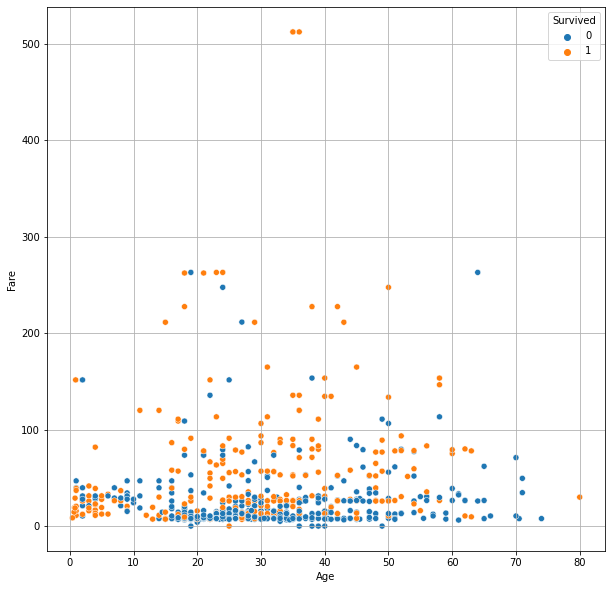

In [6]:
plt.figure(figsize=(10, 10))
sns.scatterplot(y='Fare', x='Age', data=dd, hue='Survived')
plt.grid()
plt.show()

Every decision tree creation starts with the selection of what variable and what value we should choose to split? 

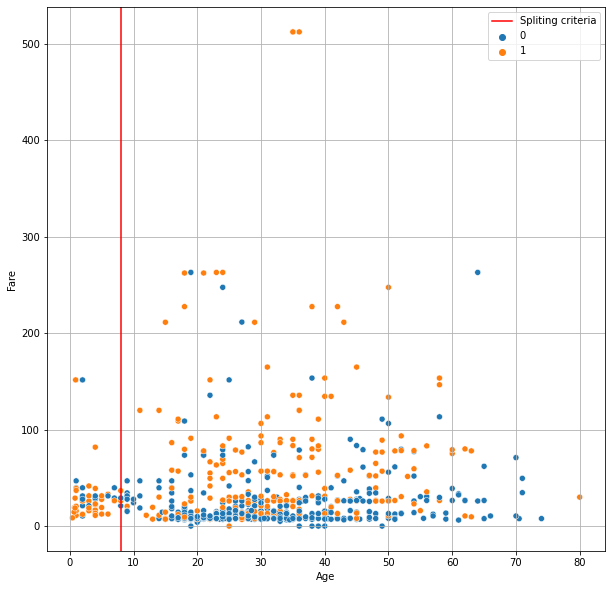

In [7]:
# Define the split value 
age_split = 8 

# Ploting the original plot
plt.figure(figsize=(10, 10))
sns.scatterplot(y='Fare', x='Age', data=dd, hue='Survived')
plt.grid()

# Adding the vertical line
plt.axvline(age_split, label='Spliting criteria', color='red')
plt.legend()
plt.show()

In [8]:
# Getting the left and right datasets
left = dd[dd['Age']<=age_split]
right = dd[dd['Age']>age_split]

We made a decision to split the data into two parts based on the visual ques from the scatterplot. Some statistics:

In [9]:
print(f"Observations to the left of criteria: {left.shape[0]}")
print(f"Observations to the right of criteria: {right.shape[0]}")

Observations to the left of criteria: 54
Observations to the right of criteria: 660


In [10]:
left.groupby('Survived', as_index=False).size()

,Survived,size
0,0,18
1,1,36


In [11]:
right.groupby('Survived', as_index=False).size()

,Survived,size
0,0,406
1,1,254


There are observations from both of the classes in the nodes. Thus, each of the nodes are are **impure**. But how impure? To measure impurity we use the **GINI** impurity coefficient. 

# GINI impurity definition 

The GINI impurity index is the default spliting criteria when building decision trees. 

The formal definition for GINI impurity is as follows: 
    
*Gini impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset.*

The definition is not very intuitive so lets bring some clarity. 

Suppose we have two classes in the dataset:

$$k_{1}, k_{2}$$. 

Each of the classes have $n_{1}$ and $n_{2}$ observations.

The probability of observing something from one of the $k$ classes is: 

$$p(i) = P(x_{i} \in k_{i}) = \dfrac{n_{i}}{n_{1} + n_{2}},  i \in \{1, 2\}$$

The GINI impurity of such a system is calculated with the following formula:
    
$$G = 1 - \Sigma_{i=1}^{2}p(i)^{2}$$

The function for calculating the impurity is in the **Node** class:

In [12]:
print(inspect.getsource(Node.GINI_impurity))

    @staticmethod
    def GINI_impurity(y1_count: int, y2_count: int) -> float:
        """
        Given the observations of a binary class calculate the GINI impurity
        """
        # Ensuring the correct types
        if y1_count is None:
            y1_count = 0

        if y2_count is None:
            y2_count = 0

        # Getting the total observations
        n = y1_count + y2_count
        
        # If n is 0 then we return the lowest possible gini impurity
        if n == 0:
            return 0.0

        # Getting the probability to see each of the classes
        p1 = y1_count / n
        p2 = y2_count / n
        
        # Calculating GINI 
        gini = 1 - (p1 ** 2 + p2 ** 2)
        
        # Returning the gini impurity
        return gini



In [13]:
# Simulating some data
n = 1000

shares_y1 = [
    0, 
    0.1,
    0.2,
    0.3,
    0.4,
    0.5, 
    0.6,
    0.7,
    0.8,
    0.9,
    1
] 

y1_counts = [x * n for x in shares_y1]
y2_counts = [n - x for x in y1_counts]

y = list(zip(y1_counts, y2_counts))

In [14]:
y

[(0, 1000),
 (100.0, 900.0),
 (200.0, 800.0),
 (300.0, 700.0),
 (400.0, 600.0),
 (500.0, 500.0),
 (600.0, 400.0),
 (700.0, 300.0),
 (800.0, 200.0),
 (900.0, 100.0),
 (1000, 0)]

In [15]:
# Getting the GINI impurities for such data
ginis = [Node.GINI_impurity(x[0], x[1]) for x in y]

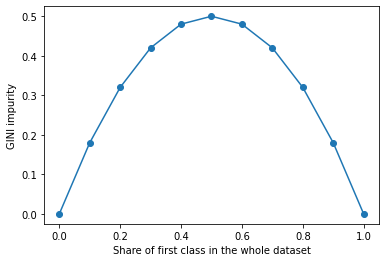

In [16]:
plt.plot(shares_y1, ginis, '-o')
plt.xlabel("Share of first class in the whole dataset")
plt.ylabel("GINI impurity")
plt.show()

The above graph shows a very important relationship. The upper bound of the GINI impurity index is 0.5. It occurs when there is an equal number of observations of each class in the dataset. This is the **worst** case in terms of GINI impurity.

At the edges of graph, we get that impurity is 0. This occurs when there is only one class in the data. This is the **best** situation. 

# GINI impurity of a split 

Going back to the example with the titanic dataset, we have two datasets resulting from the chosen split. Each of the datasets have different GINI impurity indexes. 

In [17]:
left_counts = left.groupby("Survived").size().values.tolist()
right_counts = right.groupby("Survived").size().values.tolist()

gini_left = Node.GINI_impurity(left_counts[0], left_counts[1])
gini_right = Node.GINI_impurity(right_counts[0], right_counts[1])

In [18]:
print(f"Gini impurity of the left node: {gini_left}")
print(f"Gini impurity of the right node: {gini_right}")

Gini impurity of the left node: 0.4444444444444444
Gini impurity of the right node: 0.4734802571166208


The final GINI impurity index is calculated using the weighted average based on the observation sizes in each of the datasets.

In [19]:
w1 = left.shape[0]/ (left.shape[0] + right.shape[0]) 
w2 = right.shape[0] / (left.shape[0] + right.shape[0]) 

In [20]:
gini_final = w1 * gini_left + w2 * gini_right

In [21]:
print(f"Final gini impurity: {gini_final}")

Final gini impurity: 0.4712842712842713


# GINI gain

The last metric used in deciding where to split the data is the GINI gain metric. Its calculated by the difference of non splited GINI of the dataset and the GINI of the selected split. 

In [22]:
def GINI_impurity_df(df:pd.DataFrame, target):
    """
    Function to calculate the resulting GINI impurity of a split
    """
    # Getting the counts and ginis
    counts = df.groupby(target).size().values.tolist()

    gini = Node.GINI_impurity(counts[0], counts[1])
    
    return gini

In [23]:
gini_orig = GINI_impurity_df(dd, 'Survived')

In [24]:
print(f"Gini non-splited: {gini_orig}")
print(f"Gini with the proposed split: {gini_final}")
print(f"Gini gain: {gini_orig - gini_final}")

Gini non-splited: 0.48238903404499056
Gini with the proposed split: 0.4712842712842713
Gini gain: 0.011104762760719256


At each split decision, we chose that split that has the highest GINI gain. If the GINI gain is non positive, we do not perform the split.

# Spliting on numeric variables 


When deciding where to split a numeric feature, we first sort all the values, get the means between neighbouring values and calculate the GINI gains with each of the means.

The full code to get the best split:

In [25]:
print(inspect.getsource(Node.ma))

    @staticmethod
    def ma(x: np.array, window: int) -> np.array:
        """
        Calculates the moving average of the given list. 
        """
        return np.convolve(x, np.ones(window), 'valid') / window



In [26]:
print(inspect.getsource(Node.best_split))

    def best_split(self) -> tuple:
        """
        Given the X features and Y targets calculates the best split 
        for a decision tree
        """
        # Creating a dataset for spliting
        df = self.X.copy()
        df['Y'] = self.Y

        # Getting the GINI impurity for the base input 
        GINI_base = self.get_GINI()

        # Finding which split yields the best GINI gain 
        max_gain = 0

        # Default best feature and split
        best_feature = None
        best_value = None

        for feature in self.features:
            # Droping missing values
            Xdf = df.dropna().sort_values(feature)

            # Sorting the values and getting the rolling average
            xmeans = self.ma(Xdf[feature].unique(), 2)

            for value in xmeans:
                # Spliting the dataset 
                left_counts = Counter(Xdf[Xdf[feature]<value]['Y'])
                right_counts = Counter(Xdf[Xdf[feature]>=value]['Y'])

                # Ge

# Growing the full tree

In [27]:
# Dropping missing values
dtree = d[['Survived', 'Age', 'Fare']].dropna().copy()

# Defining the X and Y matrices
Y = dtree['Survived'].values
X = dtree[['Age', 'Fare']]

# Saving the feature list 
features = list(X.columns)

In [28]:
# Setting the available hyper parameters of a tree
hp = {
    'max_depth': 3,
    'min_samples_split': 50
}

In [29]:
# Initiating the Node
root = Node(Y, X, **hp)

# Getting teh best split
root.grow_tree()

# Printing the tree information 
root.print_tree()

Root
   | GINI impurity of the node: 0.48
   | Class distribution in the node: {0: 424, 1: 290}
   | Predicted class: 0
|-------- Split rule: Fare <= 52.277
           | GINI impurity of the node: 0.44
           | Class distribution in the node: {0: 389, 1: 195}
           | Predicted class: 0
|---------------- Split rule: Fare <= 10.481
                   | GINI impurity of the node: 0.32
                   | Class distribution in the node: {0: 192, 1: 47}
                   | Predicted class: 0
|------------------------ Split rule: Age <= 32.5
                           | GINI impurity of the node: 0.37
                           | Class distribution in the node: {0: 134, 1: 43}
                           | Predicted class: 0
|------------------------ Split rule: Age > 32.5
                           | GINI impurity of the node: 0.12
                           | Class distribution in the node: {0: 58, 1: 4}
                           | Predicted class: 0
|---------------- Split rule

As it turns out, the best first split is the fare feature at value 52.227.  

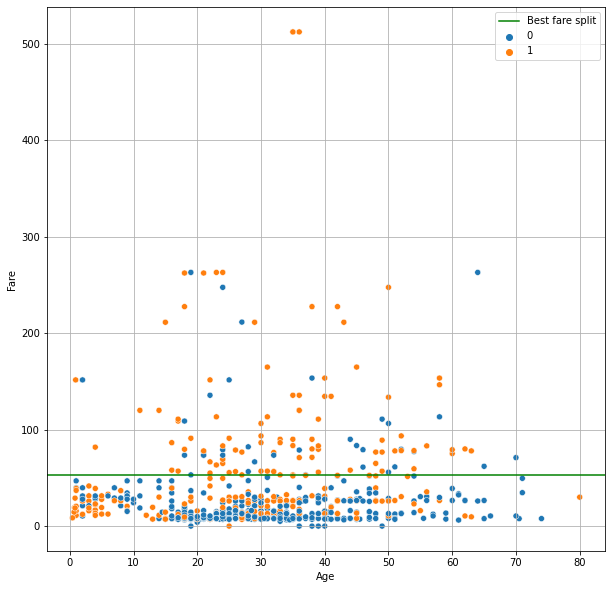

In [30]:
# Define the split value 
age_split = 8 

# Ploting the original plot
plt.figure(figsize=(10, 10))
sns.scatterplot(y='Fare', x='Age', data=dd, hue='Survived')
plt.grid()

# Adding the split line
plt.axhline(52.77, label='Best fare split', color='green')
plt.legend()
plt.show()

# Scikit-learn comparison 

The go-to machine learning framework with python is the scikit-learn package https://scikit-learn.org/stable/index.html. 
    
The package has a decision tree creation implementation: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html?highlight=decisiontree#sklearn.tree.DecisionTreeClassifier

Lets see how it compares to the custom tree creation that I have written.

In [31]:
# Constructing the hyper parameter dict
hp = {
    'max_depth': 3,
    'min_samples_split': 50
}

In [32]:
custom_tree_start = time.time()

# Initiating the Node
root = Node(Y, X, **hp)

# Getting teh best split
root.grow_tree()

custom_tree_time = time.time() - custom_tree_start

In [33]:
scikit_tree_start = time.time()

# Using the ML package 
clf = DecisionTreeClassifier(**hp)
clf.fit(X, Y)

scikit_tree_time = time.time() - scikit_tree_start

In [34]:
print(f"Custom tree growing time: {custom_tree_time}s")
print(f"Scikit tree growing time: {scikit_tree_time}s")

Custom tree growing time: 0.5011134147644043s
Scikit tree growing time: 0.0024216175079345703s


As can be expected, the highly optimized scikit-learn solution works faster.

Both methods have a visualization: 

In [35]:
root.print_tree()

Root
   | GINI impurity of the node: 0.48
   | Class distribution in the node: {0: 424, 1: 290}
   | Predicted class: 0
|-------- Split rule: Fare <= 52.277
           | GINI impurity of the node: 0.44
           | Class distribution in the node: {0: 389, 1: 195}
           | Predicted class: 0
|---------------- Split rule: Fare <= 10.481
                   | GINI impurity of the node: 0.32
                   | Class distribution in the node: {0: 192, 1: 47}
                   | Predicted class: 0
|------------------------ Split rule: Age <= 32.5
                           | GINI impurity of the node: 0.37
                           | Class distribution in the node: {0: 134, 1: 43}
                           | Predicted class: 0
|------------------------ Split rule: Age > 32.5
                           | GINI impurity of the node: 0.12
                           | Class distribution in the node: {0: 58, 1: 4}
                           | Predicted class: 0
|---------------- Split rule

In [36]:
print(export_text(clf, feature_names=['Age', 'Fare']))

|--- Fare <= 52.28
|   |--- Fare <= 10.48
|   |   |--- Age <= 32.50
|   |   |   |--- class: 0
|   |   |--- Age >  32.50
|   |   |   |--- class: 0
|   |--- Fare >  10.48
|   |   |--- Age <= 6.50
|   |   |   |--- class: 1
|   |   |--- Age >  6.50
|   |   |   |--- class: 0
|--- Fare >  52.28
|   |--- Age <= 63.50
|   |   |--- Age <= 29.50
|   |   |   |--- class: 1
|   |   |--- Age >  29.50
|   |   |   |--- class: 1
|   |--- Age >  63.50
|   |   |--- class: 0



# Predictions

In [37]:
# Result frame
results = X.copy()

# Predictions
results['scikit_learn'] = clf.predict(X[features])
results['custom_yhat'] = root.predict(X[features])

# Asserting that every prediction is the same 
np.all(results['scikit_learn'] == results['custom_yhat'])

True

All the predictions are the same. 